# Are there CopyCatch-alike clusters in the Dagster.io detector output?

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
fake = pd.read_csv("data/copycatch_test_stargazers_fake.csv")
real = pd.read_csv("data/copycatch_test_stargazers_real.csv")
fake.starred_at = pd.to_datetime(fake.starred_at).dt.tz_localize(None)
real.starred_at = pd.to_datetime(real.starred_at).dt.tz_localize(None)
fake.head()

,actor,repo_name,starred_at
0,z5,pop-os/gtk-theme,2022-01-14 10:45:33
1,z5,sjsdfg/effective-java-3rd-chinese,2020-03-01 11:46:46
2,z5,SergioBenitez/Rocket,2019-08-11 07:10:16
3,z5,xuxueli/xxl-job,2020-08-15 11:12:14
4,z5,deadc0de6/dotdrop,2019-08-14 06:06:40


## Overall Trend

We have evidence to confirm our hypothesis that on average, suspected fake accounts are more bursty. They on average star less repositories, but in each month, they on average star more. Maybe most fake accounts are still throw-away accounts that are discarded after starring a few repos.

### Distribution of Number of Repos Starred per Actor

,count,mean,std,min,25%,50%,75%,max
real,86674.0,146.337529,656.008359,1.0,12.0,43.0,131.0,121122.0
fake,86674.0,20.796917,48.667178,1.0,1.0,5.0,17.0,1256.0


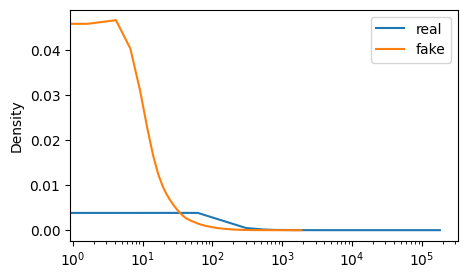

In [3]:
real_repos = real.groupby("actor").count().repo_name
fake_repos = fake.groupby("actor").count().repo_name

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_repos.plot.density(ax=ax, label="real")
fake_repos.plot.density(ax=ax, label="fake")
ax.set_xscale("log")
ax.legend()

pd.DataFrame({"real": real_repos.describe(), "fake": fake_repos.describe()}).T

### Distribution of Actor Active Range (in Days)

,count,mean,std,min,25%,50%,75%,max
real,86674.0,1021.743418,633.007805,1.0,440.0,1107.0,1647.0,1828.0
fake,86674.0,314.245114,506.843539,1.0,1.0,7.0,439.0,1828.0


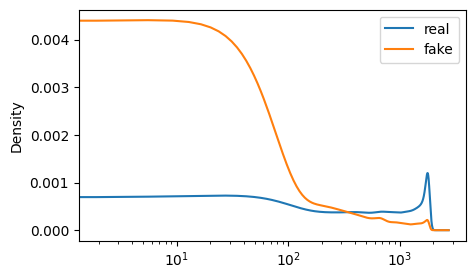

In [4]:
real_ranges = real.groupby("actor").starred_at.pipe(lambda x: x.max() - x.min()).dt.days + 1
fake_ranges = fake.groupby("actor").starred_at.pipe(lambda x: x.max() - x.min()).dt.days + 1

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_ranges.plot.density(ax=ax, label="real")
fake_ranges.plot.density(ax=ax, label="fake")
ax.set_xscale("log")
ax.legend()

pd.DataFrame({"real": real_ranges.describe(), "fake": fake_ranges.describe()}).T

### Distribution of Actor Stars per Day

,count,mean,std,min,25%,50%,75%,max
real,86674.0,0.552025,10.899984,0.001206,0.025505,0.065685,0.18847,2086.0
fake,86674.0,2.150085,6.578276,0.001149,0.043243,1.000000,1.00000,574.0


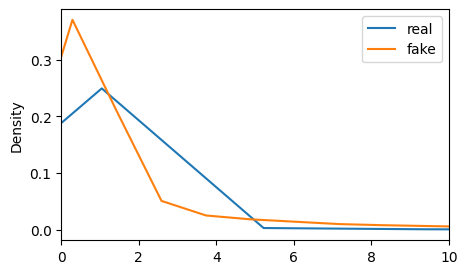

In [5]:
real_stars_per_day = real_repos / real_ranges
fake_stars_per_day = fake_repos / fake_ranges

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_stars_per_day.plot.density(ax=ax, label="real")
fake_stars_per_day.plot.density(ax=ax, label="fake")
ax.set_xlim(0, 10)
ax.legend()

pd.DataFrame({"real": real_stars_per_day.describe(), "fake": fake_stars_per_day.describe()}).T

### Time Series by Month

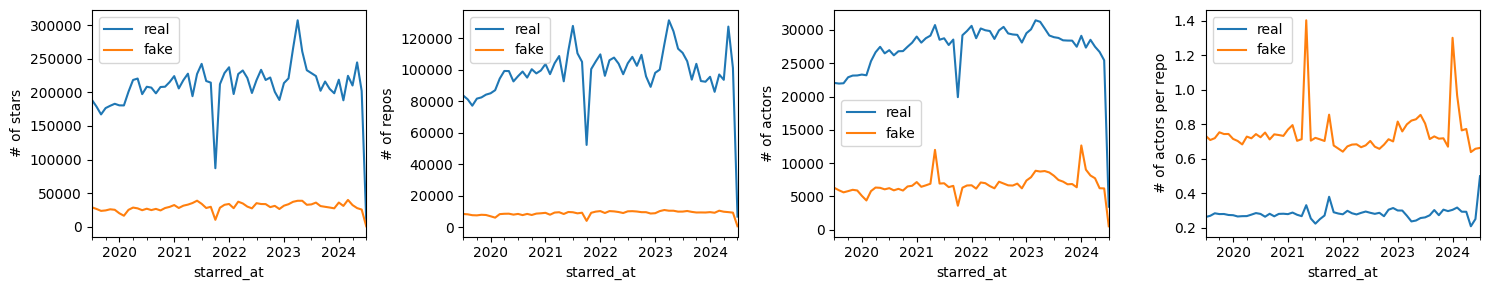

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

fake_by_month = fake.groupby(fake.starred_at.dt.to_period("M"))
real_by_month = real.groupby(real.starred_at.dt.to_period("M"))

real_by_month.size().plot(label="real", ax=axes[0])
fake_by_month.size().plot(label="fake", ax=axes[0])
axes[0].set_ylabel("# of stars")
axes[0].legend()

real_by_month.repo_name.nunique().plot(label="real", ax=axes[1])
fake_by_month.repo_name.nunique().plot(label="fake", ax=axes[1])
axes[1].set_ylabel("# of repos")
axes[1].legend()

real_by_month.actor.nunique().plot(label="real", ax=axes[2])
fake_by_month.actor.nunique().plot(label="fake", ax=axes[2])
axes[2].set_ylabel("# of actors")
axes[2].legend()

(real_by_month.actor.nunique() / real_by_month.repo_name.nunique()).plot(label="real", ax=axes[3])
(fake_by_month.actor.nunique() / fake_by_month.repo_name.nunique()).plot(label="fake", ax=axes[3])
axes[3].set_ylabel("# of actors per repo")
axes[3].legend()

fig.tight_layout()

## Per-Repo Case Studies

Very often, there are artificial spikes in the time series of star histories. From these suspicious repos, it seems that fake stars do not always have an effect in bringing real stars. The spike can range from three months to half a year.

,repo_id,repo_names,total_stars,p_fake_stars,n_fake_stars,n_low_activity,n_activity_cluster
12,MDEwOlJlcG9zaXRvcnk4OTkxMzY1NQ==,Bitcoin-ABC/bitcoin-abc,751,0.275632,207,17,190
20,MDEwOlJlcG9zaXRvcnkxMTI1MDcwODY=,30-seconds/30-seconds-of-code,75594,0.181668,13733,1488,12245
26,MDEwOlJlcG9zaXRvcnkxNzQ1MTA4NTA=,Joystream/joystream,1671,0.667265,1115,676,439
30,MDEwOlJlcG9zaXRvcnkyMTM2NDkyMTM=,paraswap/paraswap-sdk,768,0.384115,295,8,287
35,MDEwOlJlcG9zaXRvcnkyNTIxNDAyMjQ=,hydro-dev/Hydro,3089,0.218194,674,609,65
36,MDEwOlJlcG9zaXRvcnkyNTU0NjA2MTk=,holochain/holochain-client-js,230,0.804348,185,0,185
37,MDEwOlJlcG9zaXRvcnkyNzc3OTgyNzQ=,tatumio/tatum-js,432,0.377315,163,73,90
38,MDEwOlJlcG9zaXRvcnkyODUwOTIyNTI=,"serverless-stack/sst,sst/sst",13978,0.197382,2759,2396,363
39,MDEwOlJlcG9zaXRvcnkyODY3MjIyNzE=,etherspot/etherspot-sdk,406,0.536946,218,111,107
43,MDEwOlJlcG9zaXRvcnkzMjE1MzA4MDE=,subquery/subql,18485,0.597782,11050,5576,5474


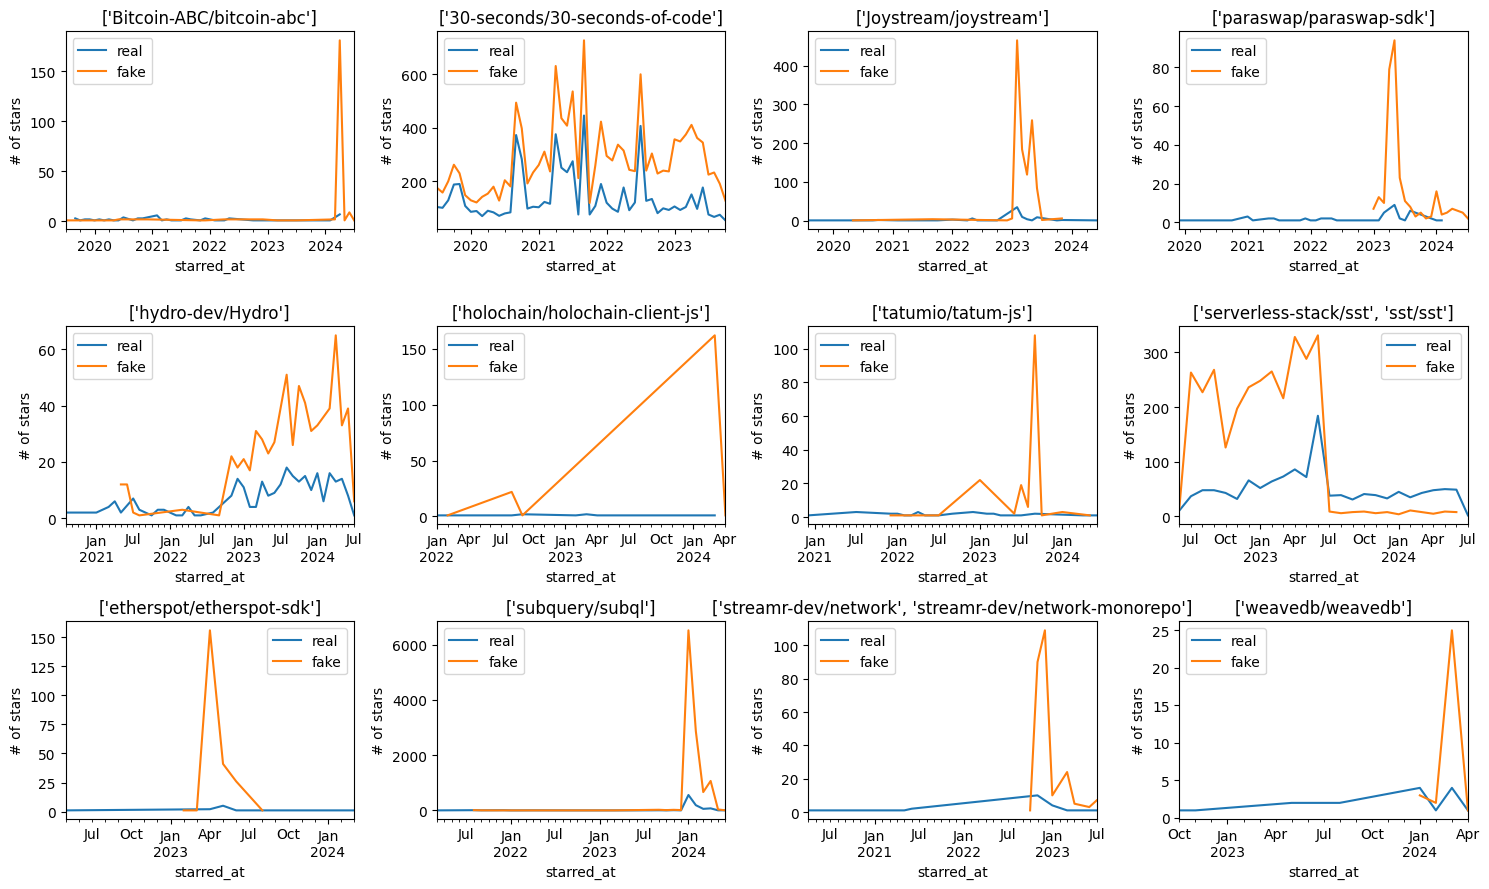

In [7]:
repos = pd.read_csv("data/fake_stars_complex_repos.csv")
suspicious_repos = repos[repos.p_fake_stars >= 0.15]

def plot_repo(ax, repos):
    real_by_repo = real[real.repo_name.isin(repos)]
    fake_by_repo = fake[fake.repo_name.isin(repos)]
    fake_by_month = fake_by_repo.groupby(fake_by_repo.starred_at.dt.to_period("M"))
    real_by_month = real_by_repo.groupby(real_by_repo.starred_at.dt.to_period("M"))
    real_by_month.size().plot(label="real", ax=ax)
    fake_by_month.size().plot(label="fake", ax=ax)
    ax.set_ylabel("# of stars")
    ax.set_title(repos)
    ax.legend()

fig, axes = plt.subplots(3, 4, figsize=(15, 9))
for i, repo_names in enumerate(suspicious_repos.repo_names):
    plot_repo(axes[i // 4][i % 4], repo_names.split(","))
fig.tight_layout()

suspicious_repos.head(12)

In [8]:
def build_bipartite_graph(stars: pd.DataFrame, actors: list[str]) -> nx.Graph:
    stars = stars[stars.actor.isin(set(actors))]
    G = nx.Graph()
    G.add_nodes_from(stars.actor, bipartite=0)
    G.add_nodes_from(stars.repo_name, bipartite=1)
    G.add_edges_from(zip(stars.actor, stars.repo_name))
    return G


def analyze_suspicious_clusters(repos: list[str], ax: plt.Axes = None):
    actors = fake[fake.repo_name.isin(repos)].actor.unique()
    G = build_bipartite_graph(fake, actors)
    repo_actors = pd.Series(
        dict(
            sorted(
                [(n, G.degree(n)) for n in G.nodes() if "/" in n],
                key=lambda x: -G.degree(x[0]),
            )
        )
    )
    if ax is not None:
        repo_actors.head(20).plot.bar(ax=ax)
        ax.set_xticks(range(20))
        ax.set_xticklabels(labels=range(20))
        ax.set_title(repos)
    return repo_actors

for repo_names in suspicious_repos.repo_names:
    print(repo_names)
    print(analyze_suspicious_clusters(repo_names.split(","), ax=None).head(10))

Bitcoin-ABC/bitcoin-abc
Bitcoin-ABC/bitcoin-abc                       210
btcsuite/btcd                                 141
etotheipi/BitcoinArmory                       107
ethereum/go-ethereum                           81
bitcoinbook/bitcoinbook                        61
okie19927648345/Valorant-Checker-Proxyless     46
onastrollnoangel43/twittter                    40
bitcoin/bitcoin                                21
virgopinkfluffy3/I-m-virgopinkfluffy3          18
maxme/bitcoin-arbitrage                        11
dtype: int64
30-seconds/30-seconds-of-code
30-seconds/30-seconds-of-code             14345
freeCodeCamp/freeCodeCamp                  5538
trekhleb/javascript-algorithms             4521
kamranahmedse/developer-roadmap            3678
EbookFoundation/free-programming-books     3093
public-apis/public-apis                    2982
MunGell/awesome-for-beginners              2980
sindresorhus/awesome                       2708
zhiwehu/Python-programming-exercises       2648
m

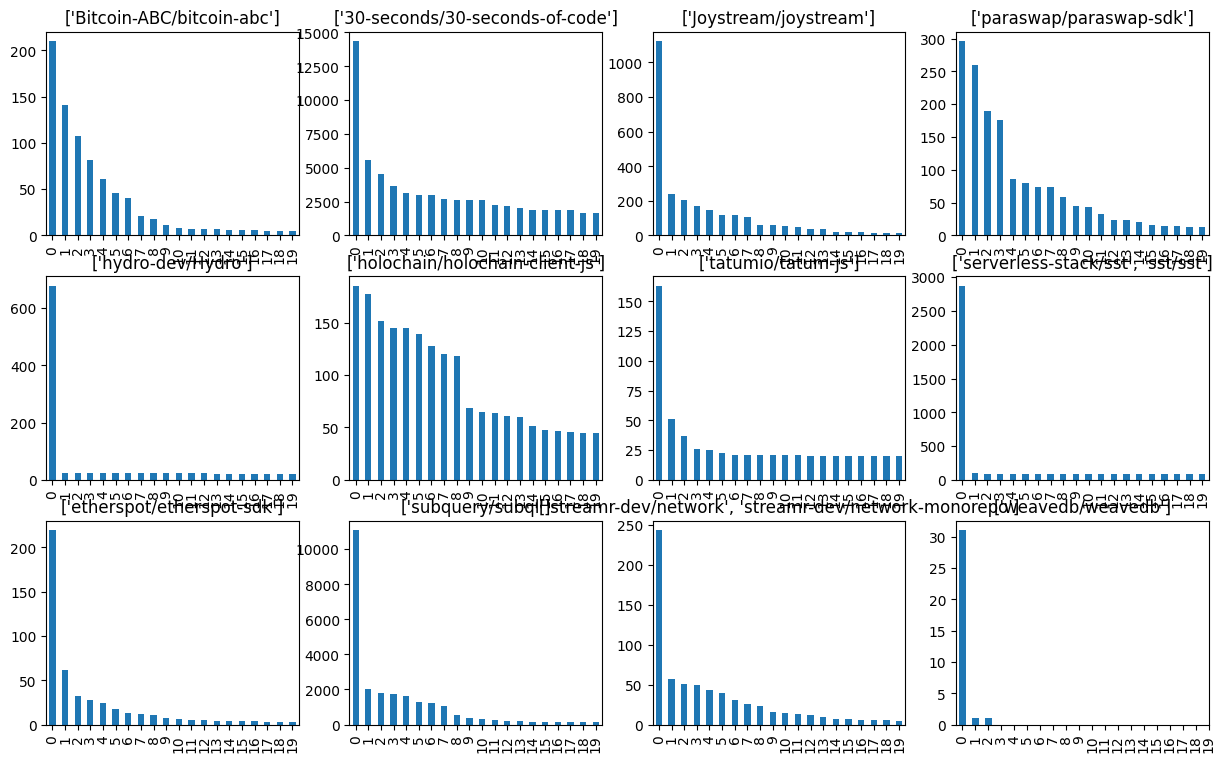

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
for i, repo_names in enumerate(suspicious_repos.repo_names):
    analyze_suspicious_clusters(repo_names.split(","), axes[i // 4][i % 4])

The results indicate that there are indeed suspicious clusters in the detected data. However, just as the dagster approach, we will need to combine two approaches: a first simple detector to find suspicious stars from low activity, and then a complex detector to find suspicous stars from activity clusters.